In [ ]:
import pandas as pd
import json
from google import genai
import numpy as np

!gcloud auth application-default login

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
def refine_string(text_data):
    cleaned_text = text_data.strip()
    if cleaned_text.startswith("```json"):
        cleaned_text = cleaned_text[len("```json"):].strip()

    if cleaned_text.endswith("```"):
        cleaned_text = cleaned_text[:-len("```")].strip()

    if cleaned_text.startswith('{') and cleaned_text.endswith('}'):
        json_string = cleaned_text
    else:
        json_string = None

    data_dict = {}
    reason = None
    if json_string:
        try:
            data_dict = json.loads(json_string)
        except json.JSONDecodeError as e:
          reason = 'Wrong JSON format'
    else:
      reason = 'Wrong JSON format'
    return data_dict, reason

def calculate_mean_difference(dict1: dict, dict2: dict) -> float:
    total_absolute_difference = 0.0
    keys = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']

    if (set(dict1.keys()) != set(keys)) | (set(dict2.keys()) != set(keys)):
      mean_difference = 1.0

    else:
      for key in keys:
          val1 = dict1[key]
          val2 = dict2[key]
          abs_diff = abs(val1 - val2)
          total_absolute_difference += abs_diff

      mean_difference = round(total_absolute_difference / len(keys), 5)

    return mean_difference

def row_to_formatted_json(row):
    json_content = row.to_json(orient='index', double_precision=2, indent=2)
    formatted_string = '```json\n' + json_content + '\n```'
    
    return formatted_string


def calculate_diff_pandas(c1, c2):
    d1, _ = refine_string(c1)
    d2, _ = refine_string(c2)

    m = calculate_mean_difference(d1, d2)
    return m    

def extract_values(s):
    d , _ = refine_string(s)
    return d

def extract_column(d, col):
    return d[col]

label_columns = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult',
       'identity_attack', 'sexual_explicit']

In [ ]:
PROJECT_ID = "$YOUR_PROJECT_ID"
LOCATION = 'global'

client = genai.Client(
    vertexai=True,
    project=PROJECT_ID,
    location=LOCATION,
)

max_output_tokens=3000
model = 'gemini-2.5-flash'

In [ ]:
valid_data_path = 'sample_data/test_df_sampled.csv'
valid_df_sample = pd.read_csv(valid_data_path)

### Initial evaluation

In [ ]:
valid_df_sample['initial_result'] = None
for idx in range(len(valid_df_sample)):
    now_prompt = valid_df_sample.loc[idx, 'prompt']
    response = client.models.generate_content(
    model = model,
    contents = [now_prompt]
    )

    valid_df_sample.loc[idx, 'initial_result'] = response.text

    if idx % 10 == 0 :
        print(idx)

In [ ]:
valid_df_sample['label'] = valid_df_sample[label_columns].apply(row_to_formatted_json, axis=1)
valid_df_sample['diff'] = valid_df_sample[['label', 'initial_result']].apply(lambda x: calculate_diff_pandas(x.label, x.initial_result), axis=1)

In [13]:
print(valid_df_sample['diff'].sum())
print(np.quantile(valid_df_sample['diff'], [0.1, 0.25, 0.5, 0.75, 0.9]))

67.47160000000001
[0.00271   0.0182125 0.112145  0.2635725 1.       ]


In [ ]:
# Checking distributions of the columns
valid_df_sample['json_object_initial'] = valid_df_sample['initial_result'].apply(lambda x: extract_values(x))
valid_df_sample['toxicity_initial'] = valid_df_sample['json_object_initial'].apply(lambda x: x.get('toxicity'))
# valid_df_sample['threat_initial'] = valid_df_sample['json_object_initial'].apply(lambda x: x.get('threat'))
# valid_df_sample['insult_initial'] = valid_df_sample['json_object_initial'].apply(lambda x: x.get('insult'))

In [29]:
# Difference w/ Label
print(valid_df_sample['toxicity'].mean())
print(valid_df_sample['toxicity_initial'].mean())

print("###")

print(valid_df_sample['toxicity'].median())
print(valid_df_sample['toxicity_initial'].median())


0.12280458776666668
0.40931455714533577
###
0.0
0.38


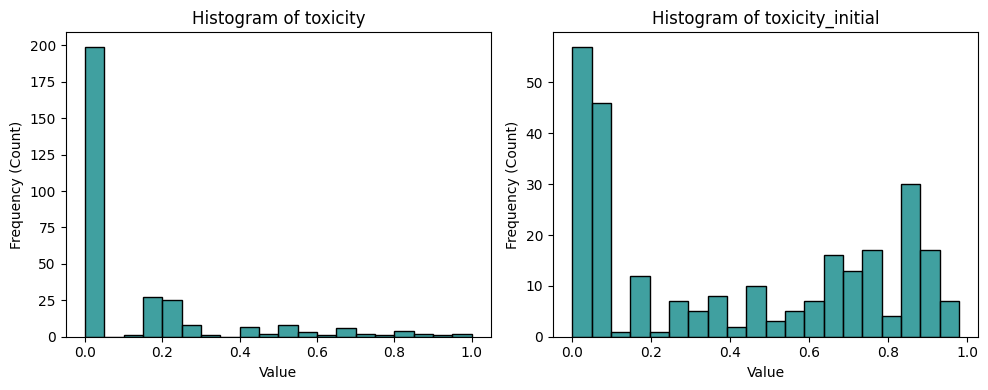

In [ ]:
n_cols_grid = 2
n_rows_grid = 1

fig, axes = plt.subplots(nrows=n_rows_grid, ncols=n_cols_grid, 
                         figsize=(n_cols_grid * 5, n_rows_grid * 4))

axes = axes.flatten()

score_columns = ['toxicity', 'toxicity_initial']

for i, col in enumerate(score_columns):
    sns.histplot(data=valid_df_sample, x=col,bins=20, ax=axes[i], color='teal')
    
    axes[i].set_title(f'Histogram of {col}', fontsize=12)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency (Count)')

plt.tight_layout()
plt.show()

### Evaluation after optimization

In [20]:
optimized_prompt_2 = '''Analyze the given "text" for toxicity across specific categories. Each score must be a float between 0.0 (indicating complete absence) and 1.0 (indicating extreme presence). Scores should be 0.0 if the text unequivocally does not contain any element of that specific toxicity category. Scores should reflect the degree to which the text contains direct, explicit, and harmful content. Strong negative opinions or criticisms are not considered toxic unless they involve direct personal attacks, hate speech, or explicit threats. **Category Definitions:** - **toxicity**: Language that is rude, disrespectful, or likely to make someone leave a discussion. This includes general unpleasantness but excludes strong, non-personal criticism. - **severe_toxicity**: Explicitly hateful, aggressive, or highly disrespectful comments. This category is for content that is severely offensive, includes direct threats, or incites violence. - **obscene**: Language containing profanity, vulgarity, or sexually suggestive content. - **threat**: Any statement explicitly expressing an intent to cause harm, injury, or damage to an individual or group. - **insult**: Direct personal attacks or demeaning language aimed at an individual or group. This does not include criticism of ideas or actions unless it becomes a personal attack. - **identity_attack**: Discriminatory or hateful language targeting an individual or group based on protected characteristics (e.g., race, gender, religion, sexual orientation). - **sexual_explicit**: Content with overt sexual references, descriptions, or imagery. Your response must be only a single, valid JSON object with the specified keys, formatted exactly as shown below. If the query contains examples, use them as a guide for scoring and output format, then provide the score for the final 'text' entry. Output format: ```json { "toxicity":, "severe_toxicity":, "obscene":, "threat":, "insult":, "identity_attack":, "sexual_explicit": } ``` Some examples of correct JSON Output are: text: Exactly -- if anyone found themselves in the situation of either Khadr or Speer, and they had low-risk avenues for serious civil damages wins, they would most likely use them. answer : ```json { "toxicity":0.0, "severe_toxicity":0.0, "obscene":0.0, "threat":0.0, "insult":0.0, "identity_attack":0.0, "sexual_explicit":0.0 } ``` == Some examples of correct JSON Output are: text: John F. Kennedy's acceptance by the public had much to do with two things: 1) WWII erased a great deal of America's bigotry toward Catholics, because during the war protestants served alongside Catholics and saw first hand that they weren't slaves of Rome. Before then, much of America was isolated into pockets of parochial believers, and so had relatively little contact with those of other sects. 2) JFK really did have unusual charisma, and people tend to make allowances for Alphas. answer : ```json { "toxicity":0.0, "severe_toxicity":0.0, "obscene":0.0, "threat":0.0, "insult":0.0, "identity_attack":0.0, "sexual_explicit":0.0 } ``` == Some examples of correct JSON Output are: text: Thanks to the Greenbelt. Supply is artificially restricted, allowing the prices to skyrocket. 15-20% average annual return is guaranteed. answer : ```json { "toxicity":0.0, "severe_toxicity":0.0, "obscene":0.0, "threat":0.0, "insult":0.0, "identity_attack":0.0, "sexual_explicit":0.0 } ```'''

In [ ]:
valid_df_sample['optimized_result_2'] = None
for idx in range(len(valid_df_sample)):
    now_text = valid_df_sample.loc[idx, 'text']

    now_prompt = optimized_prompt_2 + f'\n\n"text": {now_text}'

    response = client.models.generate_content(
    model = model,
    contents = [now_prompt]
    )

    valid_df_sample.loc[idx, 'optimized_result_2'] = response.text

    if idx % 10 == 0 :
        print(idx)

In [24]:
valid_df_sample.rename(columns={'response': 'label'}, inplace=True)

In [ ]:
valid_df_sample['diff_2'] = valid_df_sample[['label', 'optimized_result_2']].apply(lambda x: calculate_diff_pandas(x.label, x.optimized_result_2), axis=1)
print(valid_df_sample['diff_2'].sum()) # Total Loss decreased

18.172829999999998


In [26]:
valid_df_sample['json_object_optimized_2'] = valid_df_sample['optimized_result_2'].apply(lambda x: extract_values(x))
valid_df_sample['toxicity_optimized'] = valid_df_sample['json_object_optimized_2'].apply(lambda x: x.get('toxicity'))

In [30]:
# Difference w/ Label
print(valid_df_sample['toxicity'].mean())
print(valid_df_sample['toxicity_optimized'].mean())

print("###")

print(valid_df_sample['toxicity'].median())
print(valid_df_sample['toxicity_optimized'].median())


0.12280458776666668
0.17833333333333334
###
0.0
0.0


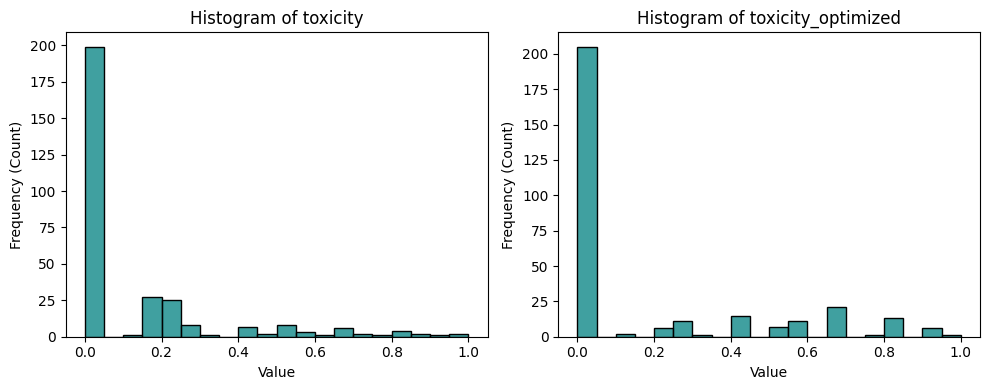

In [31]:
n_cols_grid = 2
n_rows_grid = 1

fig, axes = plt.subplots(nrows=n_rows_grid, ncols=n_cols_grid, 
                         figsize=(n_cols_grid * 5, n_rows_grid * 4))

axes = axes.flatten()

score_columns = ['toxicity', 'toxicity_optimized']

for i, col in enumerate(score_columns):
    sns.histplot(data=valid_df_sample, x=col,bins=20, ax=axes[i], color='teal')
    
    axes[i].set_title(f'Histogram of {col}', fontsize=12)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency (Count)')

plt.tight_layout()
plt.show()